# U-net forsegmenting neutrophile cells

In [1]:
# Imports:
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from csbdeep.utils import normalize

# PyTorch:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize

In [2]:
# Load images and labels
images = np.load('data/Challenge/images.npy')
labels = np.load('data/Challenge/labels.npy')

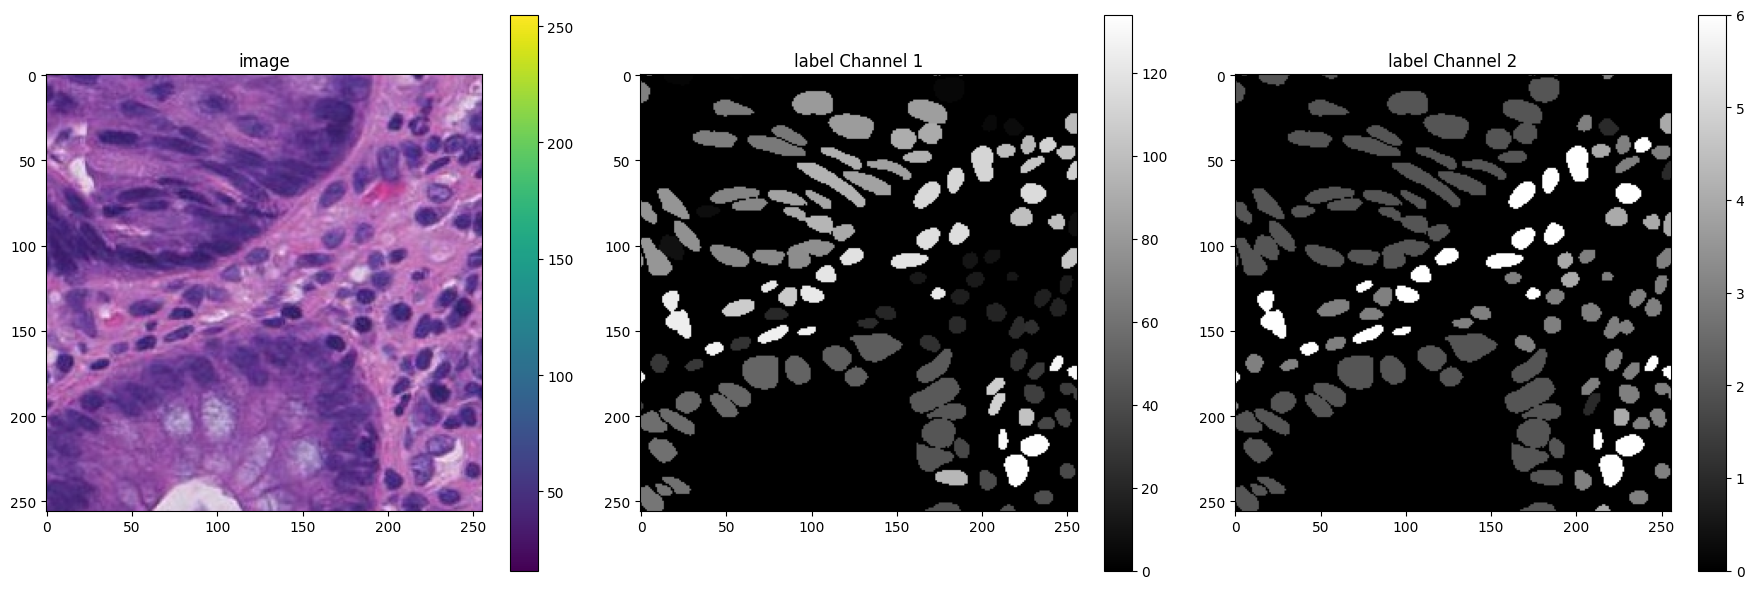

In [3]:
# Function to plot an individual channel
def plot_channel(img, title, ax, fig, cmap='gray'):
    im = ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

# Function to plot image and its corresponding label
def plot_img_label(img, lbl, img_title="image", lbl_title="label"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust for 3 subplots

    # Plot the image
    if img.ndim == 2 or img.shape[-1] == 1:
        # Grayscale image
        plot_channel(img, img_title, axs[0], fig, cmap='gray')
    elif img.shape[-1] == 3:
        # RGB image
        plot_channel(img, img_title, axs[0], fig, cmap=None)

    # Plot each channel of the label separately
    for i in range(2):
        plot_channel(lbl[..., i], f"{lbl_title} Channel {i+1}", axs[i+1], fig)

    plt.tight_layout()

# Example usage
i = 3333
img, lbl = images[i], labels[i]
assert img.ndim in (2,3)
img = img if (img.ndim == 2 or img.shape[-1] == 3) else img[..., 0]
plot_img_label(img, lbl)

In [4]:
# Filter out all cells except for Neutrophil cells:
classification_maps = labels[:, :, :, 1]
# Filter out all cells except for Neutrophil cells:
segmentation_maps = labels[:, :, :, 0]

In [5]:
# Create binary masks for Neutrophil cells (class 1)
neutrophil_masks = (classification_maps == 1).astype(np.uint16)

# Filter out all cells except for Neutrophil cells in the segmentation maps
neutrophil_segmentation_maps = segmentation_maps * neutrophil_masks

In [6]:
# Assuming images is a list of your images and labels is a list of your labels
filtered_images = []
filtered_labels = []

for i in range(len(images)):
    # Check if the neutrophil mask contains any non-zero values (presence of neutrophil cells)
    if np.any(neutrophil_segmentation_maps[i]):
        filtered_images.append(images[i])
        filtered_labels.append(neutrophil_segmentation_maps[i])

# Replace the original lists with the filtered lists
images = filtered_images
labels = filtered_labels

In [7]:
print(f"Number of images: {len(images)} and labels: {len(labels)}")

Number of images: 1218 and labels: 1218


In [8]:
# If no third dim. then number of channels = 1.
n_channel = 1 if images[0].ndim == 2 else images[0].shape[-1]

In [9]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

images_norm = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(images)]

Normalizing image channels independently.


100%|██████████| 1218/1218 [00:04<00:00, 264.26it/s]


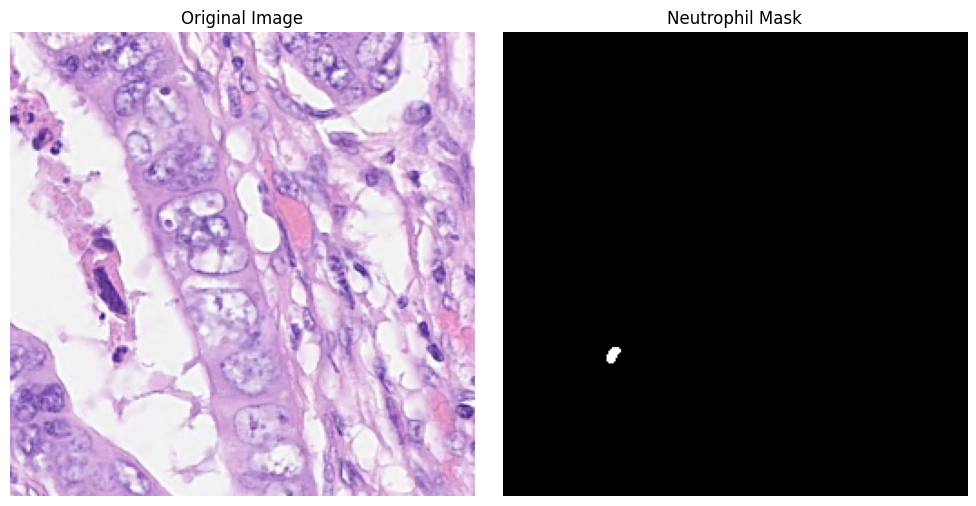

In [10]:
#Sanity check
# Function to plot image and mask side by side
def plot_image_and_mask(image, mask, img_title="Original Image", lbl_title="Neutrophil Mask"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title(img_title)
    ax[0].axis('off')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(lbl_title)
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

# Plotting the first image and its corresponding Neutrophil mask
plot_image_and_mask(images[20], labels[20])

In [11]:
# First split to separate out the test set
X_train_val, X_test, Y_train_val, Y_test = train_test_split(images_norm, labels, test_size=0.2, random_state=42)

# Second split to separate the remaining data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f'Number of images: {len(images_norm)}')
print(f'Training: {len(X_train)}')
print(f'Validation: {len(X_val)}')
print(f'Test: {len(X_test)}')


Number of images: 1218
Training: 730
Validation: 244
Test: 244


## Training

In [12]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [13]:
class NeutrophilDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Convert images to tensors
        image = ToTensor()(image)

        # Ensure mask is in float32 before converting to tensor
        mask = mask.astype(np.float32)
        mask = ToTensor()(mask)

        if self.transform:
            # Apply the transforms directly to the image
            image = self.transform(image)
            # Note: Apply any mask-specific transforms here if necessary

        return image, mask

In [14]:
# Define a transform for normalization (adjust mean and std as per your dataset)
transform = Compose([
    Normalize(mean=[0.5], std=[0.5])  # Adjust these values based on your dataset statistics
])

In [15]:
# Create dataset instances
train_dataset = NeutrophilDataset(X_train, Y_train, transform=transform)
val_dataset = NeutrophilDataset(X_val, Y_val, transform=transform)
test_dataset = NeutrophilDataset(X_test, Y_test, transform=transform)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [16]:
# Initialize the U-Net model to accept 3-channel (RGB) images
model = UNet(n_channels=3, n_classes=1)  # Change n_channels to 3 for RGB images

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-4)


In [17]:
# Number of epochs
n_epochs = 1  # Adjust the number of epochs based on your requirements

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
    
    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}')